In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn import neighbors

# Step 1. Load data as a pd DataFrame.

Ideal structure of the dataframe: article, qid, category, description.

In [4]:
df = pd.read_csv('unique_health_articles.csv')

In [5]:
df.tail()

,Unnamed: 0,article,qid,total_pageviews,description,category,page_size,incoming_links,outgoing_links,num_editors,article_age,total_revisions,total_translations,unique_days_viewed
878,878,Yoga_as_exercise,Q65091595,4324,physical activity consisting mainly of yoga poses,High-importance,105306.0,787,1178,167,2534.0,105306.0,9,42
879,879,Young_Living,Q18067581,2947,American multi-level marketing company,Low-importance,23704.0,103,179,178,4204.0,23704.0,3,28
880,880,Zero_emission_zone,Q647266,127,defined area,High-importance,59.0,1,6,1,502.0,59.0,0,2
881,881,Zumba,Q229680,42089,dance fitness program,Mid-importance,22096.0,154,142,906,7250.0,22096.0,37,333
882,882,Zyzz,Q2618609,181047,Russian-born Australian bodybuilder and Intern...,Mid-importance,24173.0,23,114,291,5232.0,24173.0,22,695


In [6]:
df.head()

,Unnamed: 0,article,qid,total_pageviews,description,category,page_size,incoming_links,outgoing_links,num_editors,article_age,total_revisions,total_translations,unique_days_viewed
0,0,1977_NestlÃ©_boycott,Q1498774,27259,boycott,Low-importance,NaN,0,0,0,NaN,NaN,0,74
1,1,2007_tuberculosis_scare,Q4609852,550,international health scare,Low-importance,16565.0,41,83,291,6771.0,16565.0,0,1
2,2,2011_United_States_listeriosis_outbreak,Q4622783,871,disease outbreak in the United States,Low-importance,23708.0,228,305,85,5190.0,23708.0,1,4
3,3,2014_California_Proposition_46,Q119129906,153,NaN,Low-importance,5373.0,957,1046,11,936.0,5373.0,1,1
4,4,24_Hour_Fitness,Q4631849,1122,US fitness center chain,Low-importance,21019.0,88,88,484,7116.0,21019.0,0,7


In [7]:
classifier_df = df[df['category'] != 'Unknown-importance']
classifier_df.category.describe()

count                750
unique                 3
top       Low-importance
freq                 472
Name: category, dtype: object

In [59]:
unknown_df = df[df['category'] == 'Unknown-importance']
unknown_df.shape

(133, 14)

# Step 2: Feature Engineering.

We want features: total_pageviews, page_size, reivisions_since_2024, incoming_number, outgoing_number.

In [9]:
onlyFeatures = classifier_df[["total_pageviews", "page_size", "incoming_links", "outgoing_links", "num_editors", "article_age", "total_revisions", "total_translations", "unique_days_viewed"]]
onlyFeatures.head()

,total_pageviews,page_size,incoming_links,outgoing_links,num_editors,article_age,total_revisions,total_translations,unique_days_viewed
0,27259,NaN,0,0,0,NaN,NaN,0,74
1,550,16565.0,41,83,291,6771.0,16565.0,0,1
2,871,23708.0,228,305,85,5190.0,23708.0,1,4
3,153,5373.0,957,1046,11,936.0,5373.0,1,1
4,1122,21019.0,88,88,484,7116.0,21019.0,0,7


There are NA values, which we need to get rid of.

In [10]:
onlyFeatures = onlyFeatures.fillna(0)

Create a dictionary of features.

In [11]:
dfDict = onlyFeatures.to_dict('records')
dfDict[:5]

[{'total_pageviews': 27259,
  'page_size': 0.0,
  'incoming_links': 0,
  'outgoing_links': 0,
  'num_editors': 0,
  'article_age': 0.0,
  'total_revisions': 0.0,
  'total_translations': 0,
  'unique_days_viewed': 74},
 {'total_pageviews': 550,
  'page_size': 16565.0,
  'incoming_links': 41,
  'outgoing_links': 83,
  'num_editors': 291,
  'article_age': 6771.0,
  'total_revisions': 16565.0,
  'total_translations': 0,
  'unique_days_viewed': 1},
 {'total_pageviews': 871,
  'page_size': 23708.0,
  'incoming_links': 228,
  'outgoing_links': 305,
  'num_editors': 85,
  'article_age': 5190.0,
  'total_revisions': 23708.0,
  'total_translations': 1,
  'unique_days_viewed': 4},
 {'total_pageviews': 153,
  'page_size': 5373.0,
  'incoming_links': 957,
  'outgoing_links': 1046,
  'num_editors': 11,
  'article_age': 936.0,
  'total_revisions': 5373.0,
  'total_translations': 1,
  'unique_days_viewed': 1},
 {'total_pageviews': 1122,
  'page_size': 21019.0,
  'incoming_links': 88,
  'outgoing_links

Now we can vectorize.

In [12]:
from sklearn.feature_extraction import DictVectorizer
import numpy as np
vec = DictVectorizer(sparse=False, dtype=np.int64)

In [13]:
X = vec.fit_transform(dfDict)

In [14]:
dfVectors = pd.DataFrame(X.tolist(),  # the data for the dataframe is a list of lists
                         columns=vec.get_feature_names_out()) # a list of feature names
dfVectors.head()

,article_age,incoming_links,num_editors,outgoing_links,page_size,total_pageviews,total_revisions,total_translations,unique_days_viewed
0,0,0,0,0,0,27259,0,0,74
1,6771,41,291,83,16565,550,16565,0,1
2,5190,228,85,305,23708,871,23708,1,4
3,936,957,11,1046,5373,153,5373,1,1
4,7116,88,484,88,21019,1122,21019,0,7


In [15]:
dfLabels = classifier_df[['article','qid', 'category']]

In [16]:
dfFinal = pd.concat([dfLabels, dfVectors], axis=1)
dfFinal.head()

,article,qid,category,article_age,incoming_links,num_editors,outgoing_links,page_size,total_pageviews,total_revisions,total_translations,unique_days_viewed
0,1977_NestlÃ©_boycott,Q1498774,Low-importance,0.0,0.0,0.0,0.0,0.0,27259.0,0.0,0.0,74.0
1,2007_tuberculosis_scare,Q4609852,Low-importance,6771.0,41.0,291.0,83.0,16565.0,550.0,16565.0,0.0,1.0
2,2011_United_States_listeriosis_outbreak,Q4622783,Low-importance,5190.0,228.0,85.0,305.0,23708.0,871.0,23708.0,1.0,4.0
3,2014_California_Proposition_46,Q119129906,Low-importance,936.0,957.0,11.0,1046.0,5373.0,153.0,5373.0,1.0,1.0
4,24_Hour_Fitness,Q4631849,Low-importance,7116.0,88.0,484.0,88.0,21019.0,1122.0,21019.0,0.0,7.0


In [17]:
dfFinal.to_csv("classifier_data.csv")

# Step 3: Train/test splitting.

In [18]:
from sklearn.model_selection import train_test_split

In [19]:
classifier_df = classifier_df.fillna(0)

X is a MATRIX Of features.

In [ ]:
X = classifier_df[["total_pageviews", "page_size", "incoming_links", "outgoing_links", "num_editors", "article_age", "total_revisions", "total_translations", "unique_days_viewed"]]
X.head()

,total_pageviews,page_size,incoming_links,outgoing_links,num_editors,article_age,total_revisions,total_translations,unique_days_viewed
0,27259,0.0,0,0,0,0.0,0.0,0,74
1,550,16565.0,41,83,291,6771.0,16565.0,0,1
2,871,23708.0,228,305,85,5190.0,23708.0,1,4
3,153,5373.0,957,1046,11,936.0,5373.0,1,1
4,1122,21019.0,88,88,484,7116.0,21019.0,0,7


In [21]:
classifier_df.shape

(750, 14)

y is the value (level of importance) we're trying to predict.

In [22]:
y = classifier_df['category']
y.shape

(750,)

In [23]:
# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y,
                                                      test_size=0.1,  
                                                      random_state=42) 

In [24]:
X_train.shape

(675, 9)

In [63]:
X_test.shape

(75, 9)

# Step 4: Multinominal logistic regression.

Create an instance of the model.

In [27]:
model = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000)

Fit the model.

https://scikit-learn.org/stable/modules/preprocessing.html

In [36]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

# Fit on training data and transform both train and test
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [37]:
model.fit(X_train_scaled, y_train)
y_pred = model.predict(X_test_scaled)

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1264: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


In [38]:
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.3f}")

Accuracy: 0.693


# Step 5: confusion matrix.

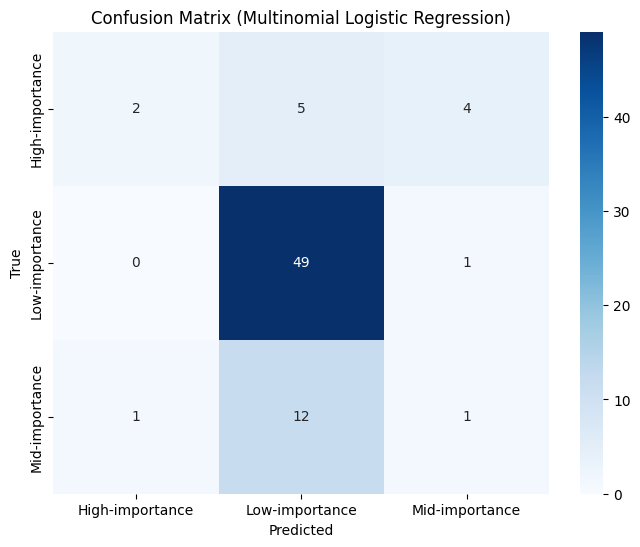

In [39]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Get the sorted list of unique labels
labels = sorted(y_test.unique())

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=labels)

# Plot using seaborn
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (Multinomial Logistic Regression)')
plt.show()

# Step 6: predict unlabeled articles.

In [41]:
unknown_df = unknown_df.fillna(0)

In [42]:
X_unlabeled = unknown_df[["total_pageviews", "page_size", "incoming_links", "outgoing_links", "num_editors", "article_age", "total_revisions", "total_translations", "unique_days_viewed"]]
X_unlabeled.head()

,total_pageviews,page_size,incoming_links,outgoing_links,num_editors,article_age,total_revisions,total_translations,unique_days_viewed
7,190,19977.0,111,157,211,7204.0,19977.0,9,1
11,1799,9761.0,8,69,76,2976.0,9761.0,1,2
14,20936,10832.0,369,137,491,8376.0,10832.0,46,170
43,391,1608.0,8,16,14,3783.0,1608.0,0,2
47,101,4336.0,3,26,34,3704.0,4336.0,2,1


In [44]:
y_unlabeled = unknown_df['category']
y_unlabeled.shape

(133,)

In [45]:
y_unlabeled_pred = model.predict(X_unlabeled)

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/validation.py:2742: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


In [49]:
y_unlabeled_pred

array(['High-importance', 'High-importance', 'Mid-importance',
       'High-importance', 'High-importance', 'High-importance',
       'High-importance', 'Low-importance', 'Low-importance',
       'Low-importance', 'High-importance', 'High-importance',
       'Low-importance', 'High-importance', 'Low-importance',
       'High-importance', 'Low-importance', 'High-importance',
       'High-importance', 'High-importance', 'High-importance',
       'Low-importance', 'High-importance', 'Low-importance',
       'Low-importance', 'High-importance', 'High-importance',
       'High-importance', 'High-importance', 'High-importance',
       'Low-importance', 'High-importance', 'Low-importance',
       'Low-importance', 'High-importance', 'High-importance',
       'High-importance', 'High-importance', 'High-importance',
       'High-importance', 'High-importance', 'High-importance',
       'High-importance', 'High-importance', 'Low-importance',
       'Low-importance', 'High-importance', 'High-impo

In [60]:
unknown_df['category'] = y_unlabeled_pred

/var/folders/f6/71_23hqx2gv3g0x_h49kbbf80000gn/T/ipykernel_67676/2948529603.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unknown_df['category'] = y_unlabeled_pred


In [61]:
unknown_df.head()

,Unnamed: 0,article,qid,total_pageviews,description,category,page_size,incoming_links,outgoing_links,num_editors,article_age,total_revisions,total_translations,unique_days_viewed
7,7,Abdominal_exercise,Q3543774,190,exercise strengthening the abdominal muscles,High-importance,19977.0,111,157,211,7204.0,19977.0,9,1
11,11,Adrianne_Ho,Q42301576,1799,actress,High-importance,9761.0,8,69,76,2976.0,9761.0,1,2
14,14,Aerobics,Q215641,20936,form of physical exercise that combines rhythm...,Mid-importance,10832.0,369,137,491,8376.0,10832.0,46,170
43,43,Andrew_Marks,Q26709623,391,American cardiologist and molecular biologist,High-importance,1608.0,8,16,14,3783.0,1608.0,0,2
47,47,Anosmia_Awareness_Day,Q25304277,101,Day to spread awareness about individuals who ...,High-importance,4336.0,3,26,34,3704.0,4336.0,2,1


In [62]:
unknown_df.to_csv('unknown_predicted.csv')

# THE REST IS JUST RESIDUAL PROCESSES.

# Step 3: Decision tree classifier.

In [64]:
from sklearn import tree

In [65]:
clf = tree.DecisionTreeClassifier(random_state=0, max_depth=2)
clf

,criterion,'gini'
,splitter,'best'
,max_depth,2
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


In [66]:
clf.fit(X_train, y_train)

,criterion,'gini'
,splitter,'best'
,max_depth,2
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


In [67]:
clf.score(X_test, y_test)

0.6933333333333334

This accuracy is quite concerningly low.

[Text(0.5, 0.8333333333333334, 'x[8] <= 284.0\ngini = 0.537\nsamples = 675\nvalue = [104.0, 422.0, 149.0]'),
 Text(0.25, 0.5, 'x[7] <= 4.5\ngini = 0.435\nsamples = 493\nvalue = [49, 357, 87]'),
 Text(0.375, 0.6666666666666667, 'True  '),
 Text(0.125, 0.16666666666666666, 'gini = 0.258\nsamples = 249\nvalue = [18, 213, 18]'),
 Text(0.375, 0.16666666666666666, 'gini = 0.556\nsamples = 244\nvalue = [31, 144, 69]'),
 Text(0.75, 0.5, 'x[2] <= 474.0\ngini = 0.665\nsamples = 182\nvalue = [55, 65, 62]'),
 Text(0.625, 0.6666666666666667, '  False'),
 Text(0.625, 0.16666666666666666, 'gini = 0.632\nsamples = 110\nvalue = [23, 52, 35]'),
 Text(0.875, 0.16666666666666666, 'gini = 0.629\nsamples = 72\nvalue = [32, 13, 27]')]

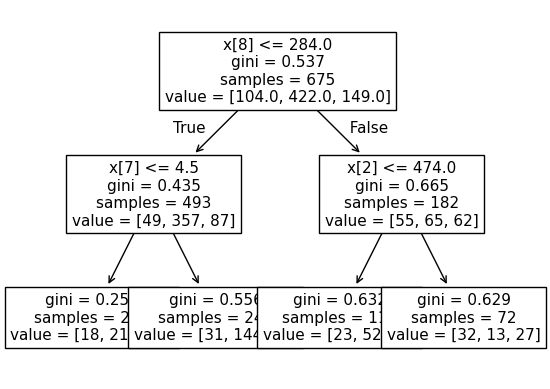

In [68]:
tree.plot_tree(clf, fontsize=11)

# Step 4: kNN classifier.

In [69]:
from sklearn import neighbors
knn = neighbors.KNeighborsClassifier() # Step 1: Build the classifier
knn

,n_neighbors,5
,weights,'uniform'
,algorithm,'auto'
,leaf_size,30
,p,2
,metric,'minkowski'
,metric_params,None
,n_jobs,None


In [70]:
knn.n_neighbors

5

In [71]:
knn.fit(X_train, y_train) # Step 2: Fit the classifier
knn.score(X_test, y_test) # Step 3: Score (validate) the classifier

0.7066666666666667

kNN is just worse, but did MUCH better when I increased the train size to 0.95?

In [72]:
predicted = knn.predict(X_test)

# show the predicted and true labels together:
print(list(zip(predicted, y_test)))

[('Low-importance', 'Low-importance'), ('High-importance', 'High-importance'), ('Low-importance', 'Low-importance'), ('High-importance', 'High-importance'), ('Low-importance', 'Low-importance'), ('Low-importance', 'Low-importance'), ('High-importance', 'Mid-importance'), ('Low-importance', 'Low-importance'), ('Low-importance', 'Low-importance'), ('Low-importance', 'Low-importance'), ('Mid-importance', 'High-importance'), ('Low-importance', 'Mid-importance'), ('High-importance', 'Mid-importance'), ('Low-importance', 'Low-importance'), ('Low-importance', 'High-importance'), ('Low-importance', 'Low-importance'), ('Low-importance', 'Low-importance'), ('Low-importance', 'Low-importance'), ('Low-importance', 'Low-importance'), ('Low-importance', 'Low-importance'), ('Low-importance', 'Mid-importance'), ('Low-importance', 'Low-importance'), ('High-importance', 'Low-importance'), ('Low-importance', 'Low-importance'), ('Low-importance', 'Mid-importance'), ('Low-importance', 'High-importance'), (

# Step 3: Grid search for kNN.

In [159]:
grid_params = {'n_neighbors': [3, 5, 7, 9, 11],    # odd number, to break ties
               'weights': ['uniform', 'distance'], # how to weigh neighbors contribution to the vote
               'metric': ['euclidean', 'cosine']
              }

In [143]:
from sklearn.model_selection import GridSearchCV
from sklearn import neighbors

gs = GridSearchCV(
    neighbors.KNeighborsClassifier(),
    grid_params,
    verbose=1,         # print output while working 
    cv=3               # number of folds for cross-validation 
)

In [144]:
gs_results = gs.fit(X_train, y_train)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


In [145]:
gs_results.best_estimator_

,n_neighbors,11
,weights,'uniform'
,algorithm,'auto'
,leaf_size,30
,p,2
,metric,'euclidean'
,metric_params,None
,n_jobs,None


In [125]:
gs_results.best_params_

{'metric': 'euclidean', 'n_neighbors': 11, 'weights': 'uniform'}

In [126]:
vectorizer = TfidfVectorizer(min_df=1, max_df=1.0)
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

In [127]:
vectorizer2 = TfidfVectorizer()
xtest = vectorizer2.fit_transform(X_test)
xtest

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 5 stored elements and shape (5, 5)>

In [129]:
for i, score in enumerate(gs_results.cv_results_['rank_test_score']):
    if score == 1:
        print(gs_results.cv_results_['params'][i])

{'metric': 'euclidean', 'n_neighbors': 11, 'weights': 'uniform'}


# Step 4: Grid search for decision tree.

In [176]:
# Step 1: initialize classifier
clf = LogisticRegression()

# Step 2: Fit the model using the training data
clf.fit(X_train, y_train)

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:470: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,100
,multi_class,'deprecated'


In [177]:
# Step 3: Predict the values on the testing data
preds = clf.predict(X_test)

# Step 4: Show a report of accuracy
print(classification_report(y_test, preds, zero_division=0))

                 precision    recall  f1-score   support

High-importance       0.33      0.27      0.30        11
 Low-importance       0.74      0.84      0.79        50
 Mid-importance       0.33      0.21      0.26        14

       accuracy                           0.64        75
      macro avg       0.47      0.44      0.45        75
   weighted avg       0.60      0.64      0.62        75



# Step 5: Draw confusion matrix.

In [214]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix_with_percentages(y_true, y_pred, 
                                           labels=[0, 1], 
                                           title="Confusion Matrix"):
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    cm_sum = cm.sum()
    cm_percent = cm / cm.sum(axis=1, keepdims=True) * 100

    annot = [[f"{count}\n{pct:.1f}%" for count, pct in zip(row, row_pct)] 
             for row, row_pct in zip(cm, cm_percent)]

    plt.figure(figsize=(4, 3))
    sns.heatmap(cm, annot=annot, fmt="", cmap="Blues", 
                xticklabels=labels, yticklabels=labels)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(title)
    plt.show()

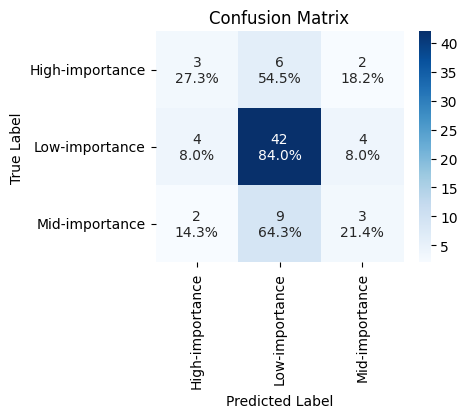

In [215]:
labels = sorted(classifier_df['category'].unique())
plot_confusion_matrix_with_percentages(y_test, preds, labels=labels)